# Sightseeing in New York City
** Extracting patterns from geolocated venues and events **

Machine learning, and in particular clustering algorithms, can be used to determine which geographical areas are commonly visited and “checked into” by a given user and which areas are not. Such geographical analyses enable a wide range of services, from location-based recommenders to advanced security systems, and in general provide a more personalized user experience. 

I will use these techniques to provide two flavours of predicting analytics: 

First, I will build a simple recommender system which will provide the most trending venues in a given area. In particular, k-means tclustering can be applied to the dataset of geolocated events to partition the map into regions. For each region, we can rank the venues which are most visited. With this information, we can recommend venues and landmarks such as Times Square or the Empire State Building depending of the location of the user.

Second, I’ll determine geographical areas that are specific and personal to each user. In particular, I will use a density-based clustering technique such as DBSCAN to extract the areas where a user usually go. This analysis can be used to determine if a given data point is an _outlier_ with respect to the areas where a user normally checks in. And therefore it can be used to score a "novelty" or "anomaly" factor given the location of a given event

We will analyze this events from a public dataset shared by Gowalla on venues checkins registered between 2008 and 2010. This notebook will cover some typical data science steps:

  - data acquisition
  - data preparation
  - data exploration
  
Thereafter, we will dive into some unsupervised learning techniques: *k-means* and *dbscan* clustering, respectively for recommending popular venues and for determining outliers.

## Imports

In [1]:
%matplotlib inline

# utils
import os
import re
import urllib

# images on the notebook
from PIL import Image

# time
import pytz as tz
from datetime import datetime

# cassandra driver
from cassandra.cluster import Cluster
from cassandra.cluster import SimpleStatement, ConsistencyLevel

# data exploration
import numpy as np
np.random.seed(1337)

import pandas as pd

In [3]:
# init
datadir = './data'

# connect to cassandra
contact_points = ['cassandra']

cluster = Cluster(contact_points)
session = cluster.connect()

In [5]:
#matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

### Loading events and venues data
Load two cassandra tables and merge them in pandas.

In [6]:
# from database
cql_stmt = """
    SELECT * from lbsn.events;
"""
rows = session.execute(cql_stmt)
dfe = pd.DataFrame(list(rows))

cql_stmt = """
    SELECT * from lbsn.venues;
"""
rows = session.execute(cql_stmt)
dfv = pd.DataFrame(list(rows))

df = pd.DataFrame.merge(dfe,dfv[['vid', 'name']], on='vid', how="inner")
print(df.shape)
df.head(3)

(112382, 6)


uid                  ts        lat        lon     vid      name
0  118712 2010-06-28 13:42:51  40.760333 -73.965363  286922  Felidias
1   33197 2010-05-05 22:52:38  40.760333 -73.965363  286922  Felidias
2    1274 2010-01-25 23:10:16  40.760333 -73.965363  286922  Felidias

### Exploring events on the map

In [7]:
def get_map(x,y,z,size, filename) :
    static_map = "http://staticmap.openstreetmap.de/staticmap.php?center={0},{1}&zoom={2}&size={3}x{3}&maptype=mapnik".format(y,x,z,size)

    static_map_filename, headers = urllib.request.urlretrieve(static_map, filename)
    return static_map_filename

def geomap(data, zoom=13, point_size=3, point_color='r', point_alpha=1):
    #corrections to match geo with static map
    z=zoom
    picsize=1000
    wx = 1.0*360*(picsize/256)/(2**z) 
    wy = 0.76*360*(picsize/256)/(2**z) 

    #center of manhattan
    y = 40.7502
    x = -73.9752

    x_min, x_max = x-wx/2, x+wx/2
    y_min, y_max = y-wy/2, y+wy/2

    static_map_filename = os.path.join(datadir, 'nyc_staticmap_{}_{}.png'.format(z,picsize))

    if os.path.isfile(static_map_filename)==False:
        get_map(x,y,z,picsize,static_map_filename)

    img = Image.open(static_map_filename)

    #add the static map
    plt.imshow(img,zorder=0, extent=[x_min, x_max, y_min, y_max], interpolation='none', aspect='auto')

    #add the scatter plot of events
    plt.plot( 
        data['lon'], 
        data['lat'], 
        '.', 
        markerfacecolor=point_color, 
        markeredgecolor='k', 
        markersize=point_size, 
        alpha=point_alpha)

    #limit the plot to the given box
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)



## Exploring users' geo-located patterns

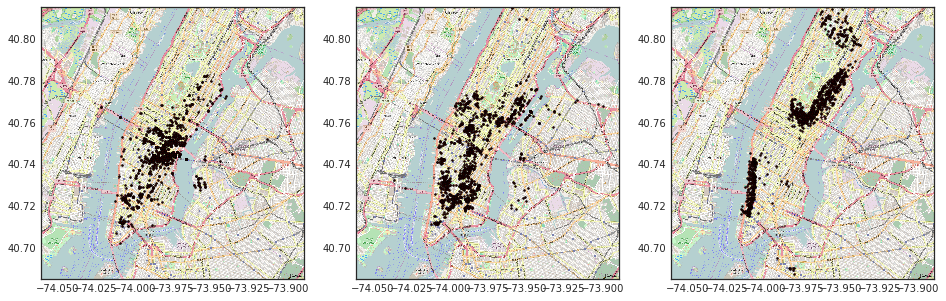

In [9]:
#prepare the figure
plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(16,5)

plt.subplot(1, 3, 1)
geomap(dfe[dfe['uid']==578][['lon','lat']])

plt.subplot(1, 3, 2)
geomap(dfe[dfe['uid']==22][['lon','lat']])

plt.subplot(1, 3, 3)
geomap(dfe[dfe['uid']==842][['lon','lat']])

plt.show()

In [10]:
from sklearn.cluster import DBSCAN

uid =22 #842 #4902

#1deg at 40deg latitude is 111034.61 meters
#set radius at 260 mt
eps = 260/111034.61

data = dfe[dfe['uid']==uid][['lon','lat','vid']]
db = DBSCAN(eps=eps, min_samples=3).fit(np.array(data[['lon','lat']]))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

data['dbscan_cluster'] =  db.labels_
data['dbscan_core']    = core_samples_mask
print("# clusters: {}".format(len(set(data['dbscan_cluster']))))

# clusters: 26


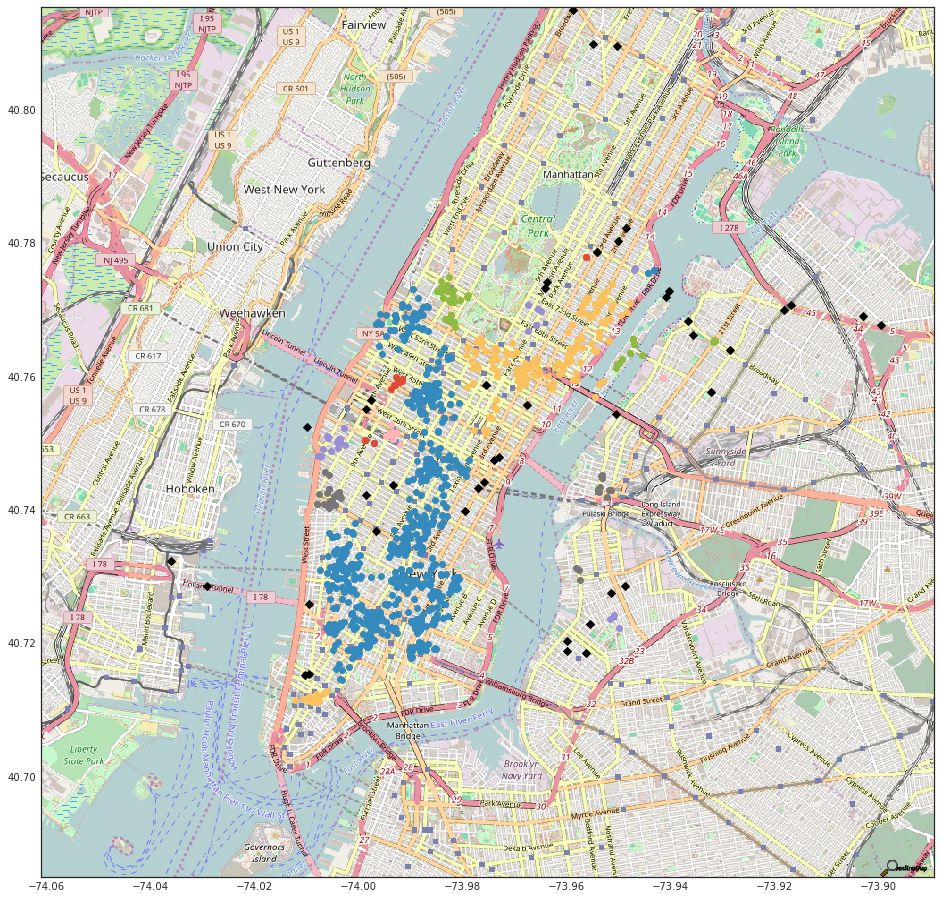

In [12]:
# prepare figure
plt.style.use('seaborn-white')
fig = plt.figure()

empty= pd.DataFrame(columns=['lon','lat'])
geomap(empty, 13, 2,'k',0.1)

unique_labels = sorted(set(data['dbscan_cluster']))

for k in unique_labels:
    xy = data[data['dbscan_cluster']==k]
    plt.plot(xy['lon'], xy['lat'], 'kD' if k<0 else 'o', markersize=6)

plt.show()

### Summarizing clusters using convex hulls

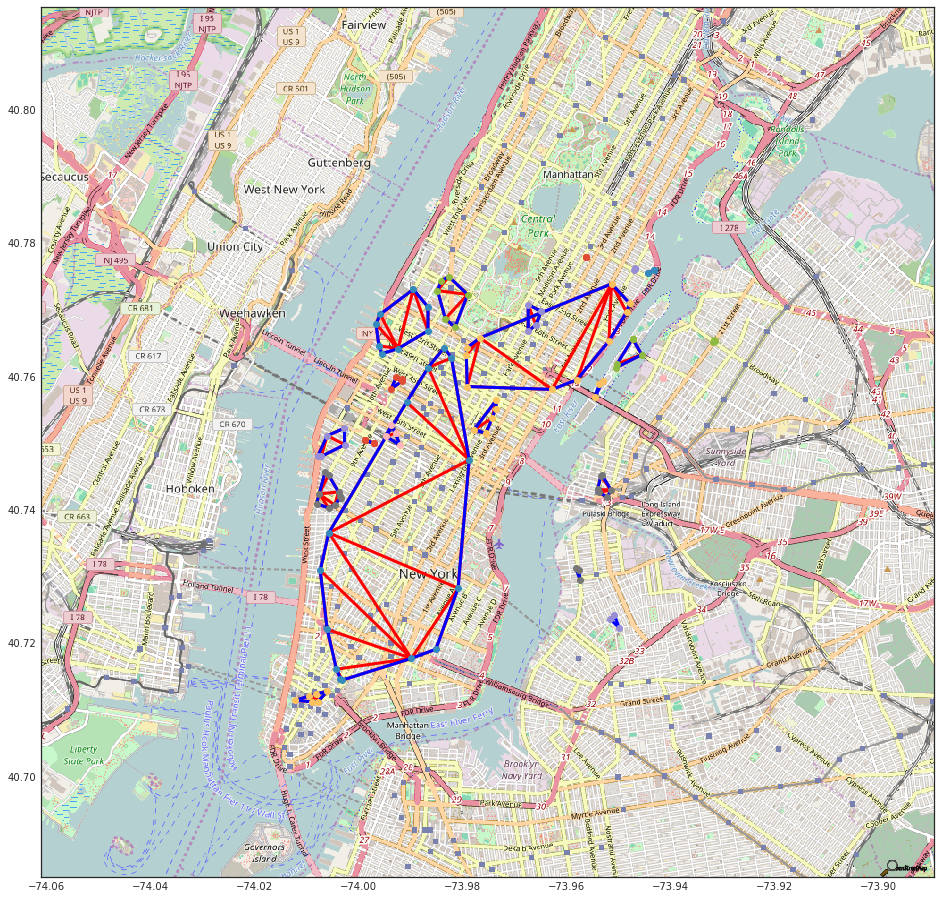

In [14]:
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

plt.style.use('seaborn-white')
fig = plt.figure()

empty= pd.DataFrame(columns=['lon','lat'])
geomap(empty, 13, 2,'k',0.1)

for k in unique_labels:
    if k>=0:
        points = data[data['dbscan_cluster']==k][['lon','lat']].reset_index(drop=True).as_matrix()
        try:
            hull = ConvexHull(points, qhull_options='QJ Pp')
            hull_vertices = np.array([ [points[i][0], points[i][1]] for i in hull.vertices ])

            #convex hull
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], 'b-', lw=3)
            
            # triangulation of convex hull vertices
            if hull_vertices.shape[0]>3:
                tri = Delaunay(hull_vertices, qhull_options='QJ Pp')
                plt.triplot(hull_vertices[:,0], hull_vertices[:,1], tri.simplices.copy(), 'r-', lw=3)

            # plot the points
            plt.plot(hull_vertices[:,0], hull_vertices[:,1], 'o', lw=3)
        except:
            pass

plt.show()    

#### How big are the regions?

In [15]:
stats = []

for k in unique_labels:
    if k>=0:
        xy = data[data['dbscan_cluster']==k][['lon','lat']].reset_index(drop=True)
        try:
            hull = ConvexHull(xy.as_matrix(), qhull_options='QJ Pp')
            stats.append([k,hull.area, hull.npoints])
        except:
            pass

stats_df = pd.DataFrame(stats, columns=['cluster', 'area', 'count'])
stats_df.sort_values(by='area', ascending=False).head(5)

cluster      area  count
0         0  0.124447    742
3         3  0.076629    194
14       14  0.030659     48
11       11  0.019936     28
9         9  0.015215     26

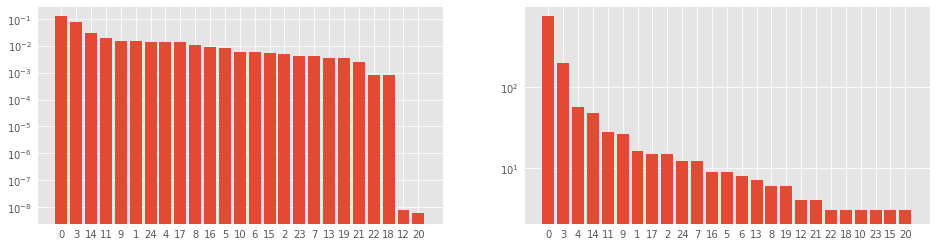

In [16]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(16,4)

plt.subplot(1, 2, 1)
stats_df = stats_df.sort_values('area', ascending=False).reset_index(drop=True)
plt.bar(stats_df.index, stats_df['area'],align='center', log=True)
plt.xticks(range(len(stats_df)),stats_df['cluster'])

plt.subplot(1, 2, 2)
stats_df = stats_df.sort_values('count', ascending=False).reset_index(drop=True)
plt.bar(stats_df.index, stats_df['count'],align='center', log=True)
plt.xticks(range(len(stats_df)),stats_df['cluster'])

plt.show()

In [17]:
hulls = []

for k in unique_labels:
    if k>=0:
        xy = data[data['dbscan_cluster']==k][['lon','lat']].reset_index(drop=True)
        xy = xy.as_matrix()
        try:
            hull = ConvexHull(xy, qhull_options='QJ Pp')
            hull_vertices = [ [xy[i][0], xy[i][1]] for i in hull.vertices ]
            hulls.append(hull_vertices)
        except:
            pass

In [18]:
from scipy.spatial import Delaunay
def in_hull(p, convexhull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    if not isinstance(convexhull,Delaunay):
        try:
            hull = Delaunay(convexhull, qhull_options='QJ Pp')
            res  = hull.find_simplex(p)>=0
        except:
            res = False

    return res

In [19]:
def location_alert(hulls, lon, lat):
    """
    Determine if the given point is within any of the given convex hulls
    If not, it gives  
    """
    result = False
    for k in list(range(len(hulls))):
        result = result or in_hull([lon, lat], hulls[k])
    return (not result)

In [20]:
location_alert(hulls, -73.99, 40.75)


False

In [21]:
location_alert(hulls, -73.89, 70.75)

True